<a href="https://colab.research.google.com/github/GabEscom/ROBOT_TRADING_ALURA/blob/main/Robot_Trading_Gab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<font color=cyan>**1. Configuración del Ambiente**


In [ ]:
pip install matplotlib


In [ ]:
pip install yfinance

In [ ]:
# Bibliotecas
import sys
import bs4
from urllib.request import urlopen, urlretrieve, Request
import requests
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
from IPython.display import clear_output
import time
from datetime import datetime


##<font color=cyan>**2. Obtención de datos**

In [ ]:
## Importar base de datos de bitcoin

def importar_base_bitcoin():
  global df_bitcoin
  df_bitcoin= yf.download("BTC-USD", interval="5m", period="7d")


In [ ]:
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-27 00:00:00+00:00,34156.500000,34166.277344,34134.558594,34134.558594,34134.558594,0
2023-10-27 00:05:00+00:00,34142.019531,34142.019531,34113.355469,34113.355469,34113.355469,0
2023-10-27 00:10:00+00:00,34109.191406,34123.269531,34095.777344,34095.777344,34095.777344,0
2023-10-27 00:15:00+00:00,34113.597656,34113.597656,34072.480469,34072.480469,34072.480469,7481344
2023-10-27 00:20:00+00:00,34076.945312,34123.214844,34076.945312,34123.214844,34123.214844,612352


In [ ]:
## Importar datos desde https://coinmarketcap.com/

def extraer_tendencia():
  global precio_actual, tendencia
  url='https://coinmarketcap.com/'
  response = requests.get(url)
  soup = BeautifulSoup(response.content, features='lxml')

  ## Obtener Precio actual
  price=soup.find('div', {'class':['sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY rise','sc-a0353bbc-0 gDrtaY fall']}).getText()
  precio_actual=float(price.strip('$').replace(',', '').strip())

  ## Obtener valor del cambio 1H
  change=soup.find('span', class_='sc-d55c02b-0 iwhBxy').getText()
  cambio=float(change.strip('%').replace(',', '').strip())

  ## Obetener tendencia
  trend=soup.findAll('span', class_='sc-d55c02b-0 gUnzUB')[0].find_next(class_=True)
  tendencia=None

  if 'icon-Caret-up' in trend['class']:
          tendencia='alta'
  else :
          tendencia='baja'

In [ ]:
extraer_tendencia()
print('Precio Bitcoin (USD): ', precio_actual)
print('Tendencia: ', tendencia)

Precio Bitcoin (USD):  35625.94
Tendencia:  alta


##<font color=cyan>**3. Limpieza de datos**

<Axes: >

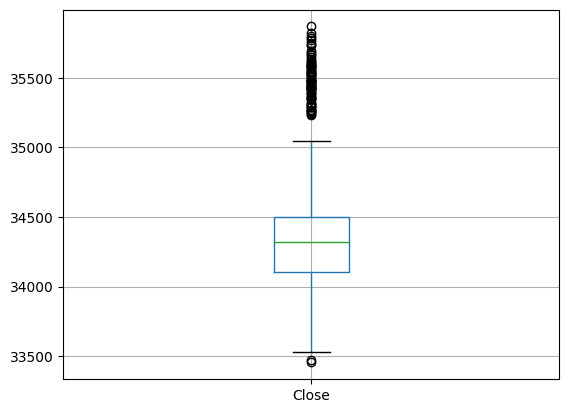

In [ ]:
# identificar outliers
df_bitcoin.boxplot(['Close'])

In [ ]:
# Copia del df
df_bitcoin_limpio = df_bitcoin.copy()

# Filtrar valores unicos en el índice
df_bitcoin_limpio.index = pd.to_datetime(df_bitcoin_limpio.index)
df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
#df_bitcoin_limpio = df_bitcoin_limpio.drop_duplicates(subset=['Datetime'], keep='first')

df_bitcoin_limpio.shape[0]


1773

<Axes: >

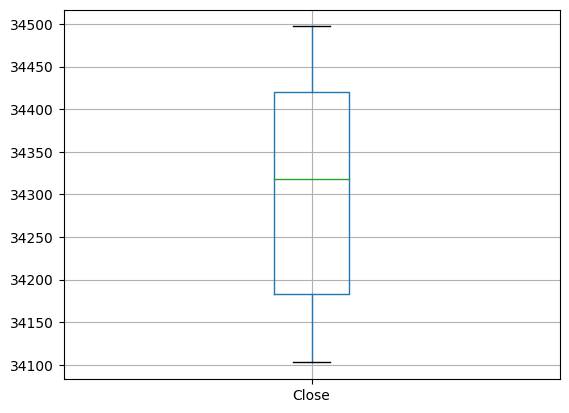

In [ ]:
# Remover outliers
bitcoin_cierre= df_bitcoin_limpio['Close']
Q1 = bitcoin_cierre.quantile(0.25)
Q3 = bitcoin_cierre.quantile(0.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ
seleccion=(bitcoin_cierre > Q1) & (bitcoin_cierre < Q3)
df_bitcoin_limpio_B = df_bitcoin_limpio[seleccion]
df_bitcoin_limpio_B.boxplot(['Close'])

In [ ]:
# Calcular el valor promedio de los valores de la columna 'Close'
media_bitcoin = df_bitcoin_limpio['Close'].mean()
media_bitcoin

34338.76940787154

In [ ]:
def limpieza_datos():
    global media_bitcoin

    # Copia del df
    df_bitcoin_limpio = df_bitcoin.copy()

    # Filtrar valores unicos en el índice
    df_bitcoin_limpio.index=pd.to_datetime(df_bitcoin_limpio.index)
    df_bitcoin_limpio=df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

    # Eliminar valores nulos de la columna 'Close'
    df_bitcoin_limpio=df_bitcoin_limpio.dropna(subset=['Close'])

    # Filtrar valores de 'Volume' superiores a cero
    df_bitcoin_limpio=df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    # identificar y remover outliers
    bitcoin_cierre= df_bitcoin_limpio['Close']
    Q1=bitcoin_cierre.quantile(0.25)
    Q3=bitcoin_cierre.quantile(0.75)
    seleccion=(bitcoin_cierre > Q1) & (bitcoin_cierre < Q3)
    df_bitcoin_limpio=df_bitcoin_limpio[seleccion]


    # Calcular el valor promedio de los valores de la columna 'Close'
    media_bitcoin=df_bitcoin_limpio['Close'].mean()


In [ ]:
limpieza_datos()
print('Precio Proedio Bitcoin (USD): ', media_bitcoin)

Precio Proedio Bitcoin (USD):  34425.156547704966


##<font color=cyan>**4. Tomar decisiones**

In [ ]:
def tomar_decisiones():
  global  algoritmo_decision
  algoritmo_decision=[]
  if precio_actual >= media_bitcoin and tendencia == 'baja':
      algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
      algoritmo_decision = 'Comprar'
  else:
      algoritmo_decision = 'Esperar'


In [ ]:
tomar_decisiones()
print('Decisión', algoritmo_decision)

Decisión Esperar


##<font color=cyan>**5. Visualización**

In [ ]:
def visualizacion():

  # Adicionar una nueva columna "Promedio"
  df_bitcoin['Promedio'] = media_bitcoin

  # Configurar el tamaño del gráfico y Título
  plt.figure(figsize=(16, 5))
  plt.title('Robot Trading')

  # Dibujar una línea con los datos del índice y la columna 'Close'
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio de Cierre', color='b')


  # Dibujar una línea con los datos del índice y la columna 'Promedio'

  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio', color='r')

  # Resaltar el último precio de cierre con un marcador circular
  ultimo_valor = df_bitcoin['Close'].iloc[-1]
  plt.scatter(df_bitcoin.index[-1], ultimo_valor, color='b', s=100, zorder=3)
  plt.text(df_bitcoin.index[-1], ultimo_valor, f'{ultimo_valor:.2f}', color='black', fontsize=12, ha='left', va='center')

  # Mostrar un mensaje con la decisión del algoritmo en el gráfico

  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(0.90, 0.90), xycoords='axes fraction', ha='center', fontsize=12)

  print("Hora de ejecución:", datetime.now())
  print('Precio Promedio Bitcoin: ', media_bitcoin)
  print('Precio Actual Bitcoin: ', precio_actual)
  print('Tendencia: ', tendencia)
  plt.show()

Hora de ejecución: 2023-11-02 03:43:47.742554
Precio Promedio Bitcoin:  34375.072594916346
Precio Actual Bitcoin:  35625.94
Tendencia:  alta


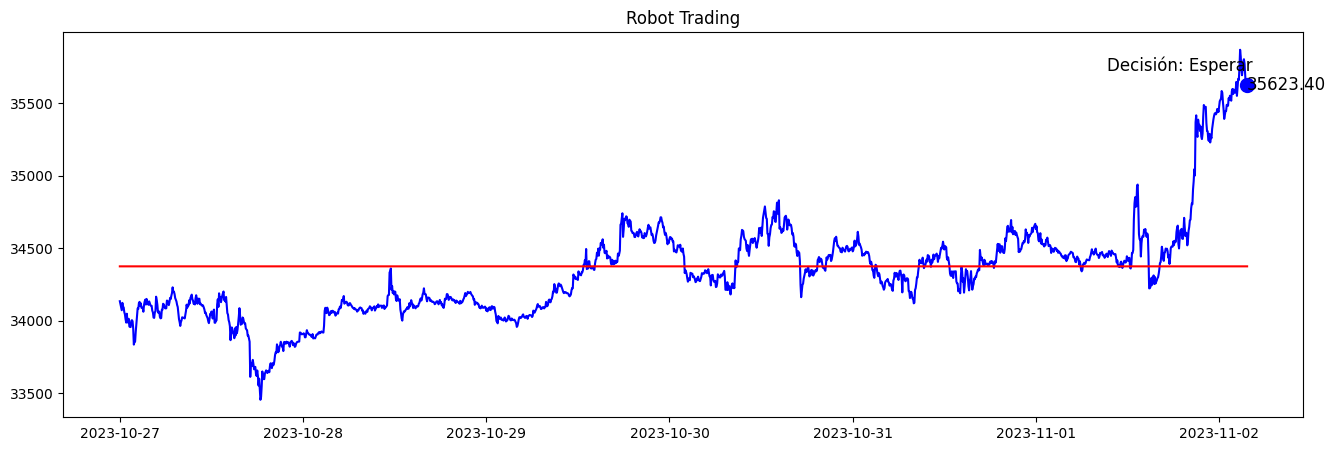

In [ ]:
visualizacion()

##<font color=cyan>**6. Automatización**

[*********************100%%**********************]  1 of 1 completed
Hora de ejecución: 2023-11-02 04:04:30.957687
Precio Promedio Bitcoin:  34426.83984375
Precio Actual Bitcoin:  35599.65
Tendencia:  baja


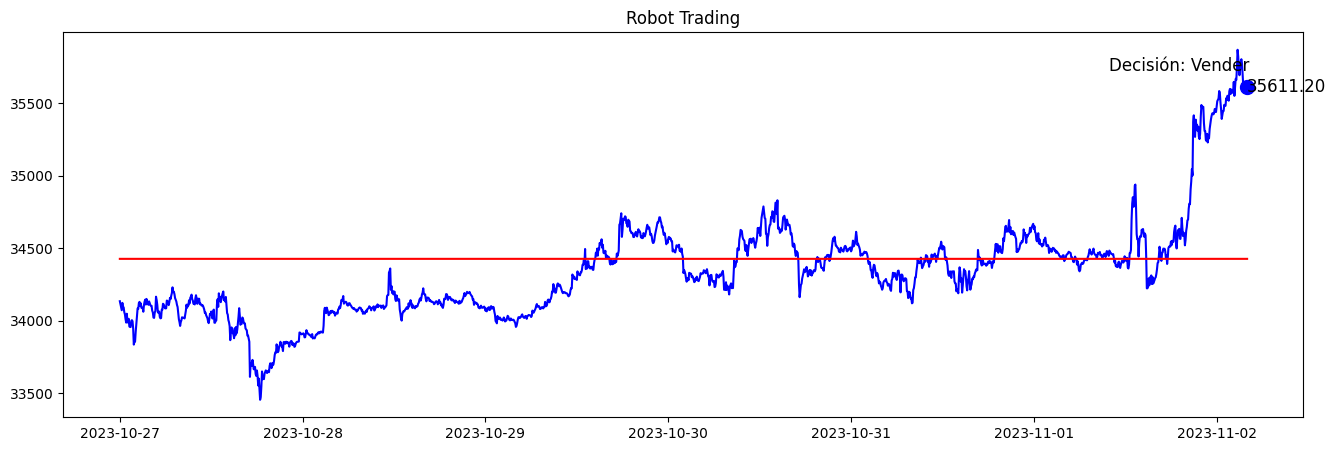

KeyboardInterrupt: ignored

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencia()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)